### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# ! wget  https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip
# ! unzip -qq data.zip -d data

--2023-09-28 19:01:06--  https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/vgqpz2f1lolxmlv/data.zip [following]
--2023-09-28 19:01:06--  https://www.dropbox.com/s/raw/vgqpz2f1lolxmlv/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc847af85ef5da0419788a486df1.dl.dropboxusercontent.com/cd/0/inline/CEnJTF_4wLIlfgWR9SaHeFQaLj3yMV1btnN4Al7T4pHewfLMEO3dUxqGKB_KxlQQ9zXi5zrgUhaUMzmSVCDYkqa1lQ-SynWuTwCKU4kBWAByRMxiuikUS3STukH9DyUkrgk/file# [following]
--2023-09-28 19:01:07--  https://uc847af85ef5da0419788a486df1.dl.dropboxusercontent.com/cd/0/inline/CEnJTF_4wLIlfgWR9SaHeFQaLj3yMV1btnN4Al7T4pHewfLMEO3dUxqGKB_KxlQQ9zXi5zrgUhaUMzmSVCDYkqa1lQ-SynWuTwCKU4kBWAByRMxiuikUS3STukH9DyUkrgk/fi

In [1]:
%pip install torchmetrics

In [2]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy

from matplotlib import pyplot as plt
import numpy as np
import time
from collections import defaultdict
from tqdm.auto import tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# DATA_PATH = os.path.join('drive', 'MyDrive', 'Datasets', 'Dog breeds', 'data')
DATA_PATH = os.path.join('data', 'data')
# CHECKPOINT_PATH = os.path.join('drive', 'MyDrive', 'models', 'ml_course')
NUM_WORKERS = 2
SIZE_H = SIZE_W = 128
NUM_CLASSES = 50
EPOCH_NUM = 30
BATCH_SIZE = 128
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

In [4]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])
transformer_augmented = transforms.Compose([
    transforms.RandomRotation((-5, 5)),
    transforms.RandomCrop(72, 72),
    transforms.RandomEqualize(p=0.3),
    transforms.RandomAutocontrast(p=0.5),
    transforms.Resize((SIZE_H, SIZE_W)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])

In [ ]:
# dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer)
# dataset_aug = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer_augmented)

In [ ]:
# train_dataset_or, val_dataset_or = torch.utils.data.random_split(dataset=dataset, lengths=(0.7, 0.3))
# train_dataset_aug, val_dataset_aug = torch.utils.data.random_split(dataset=dataset_aug, lengths=(0.7, 0.3))
# train_dataset = train_dataset_or + train_dataset_aug
# val_dataset = val_dataset_or + val_dataset_aug

In [5]:
dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer)
train_dataset, val_dataset = torch.utils.data.random_split(dataset=dataset, lengths=(0.75, 0.25))

In [6]:
label = dict()

for i in val_dataset:
    if i[1] in label:
        label[i[1]] += 1
    else:
        label[i[1]] = 1
label

{32: 42,
 26: 31,
 40: 31,
 33: 42,
 44: 39,
 41: 39,
 12: 27,
 42: 35,
 29: 50,
 48: 40,
 49: 33,
 19: 42,
 15: 27,
 7: 31,
 27: 31,
 24: 38,
 5: 36,
 4: 35,
 20: 34,
 18: 65,
 39: 26,
 36: 34,
 34: 32,
 6: 47,
 43: 44,
 9: 37,
 0: 41,
 14: 31,
 21: 28,
 2: 34,
 35: 47,
 13: 34,
 1: 36,
 22: 30,
 10: 36,
 31: 58,
 28: 38,
 17: 31,
 47: 34,
 11: 36,
 16: 32,
 25: 34,
 45: 31,
 3: 29,
 30: 36,
 23: 30,
 38: 38,
 46: 26,
 8: 31,
 37: 22}

In [7]:
len(train_dataset), len(val_dataset)

(5375, 1791)

In [ ]:
# test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test'), transform=transformer)
# len(test_dataset)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                          batch_size=BATCH_SIZE,
#                                          num_workers=NUM_WORKERS)

In [9]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    for i in range(grid_size[0] * grid_size[1]):

        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)

        # display batch samples with labels
        sample_title = 'Label = %d' % (label_batch[i])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

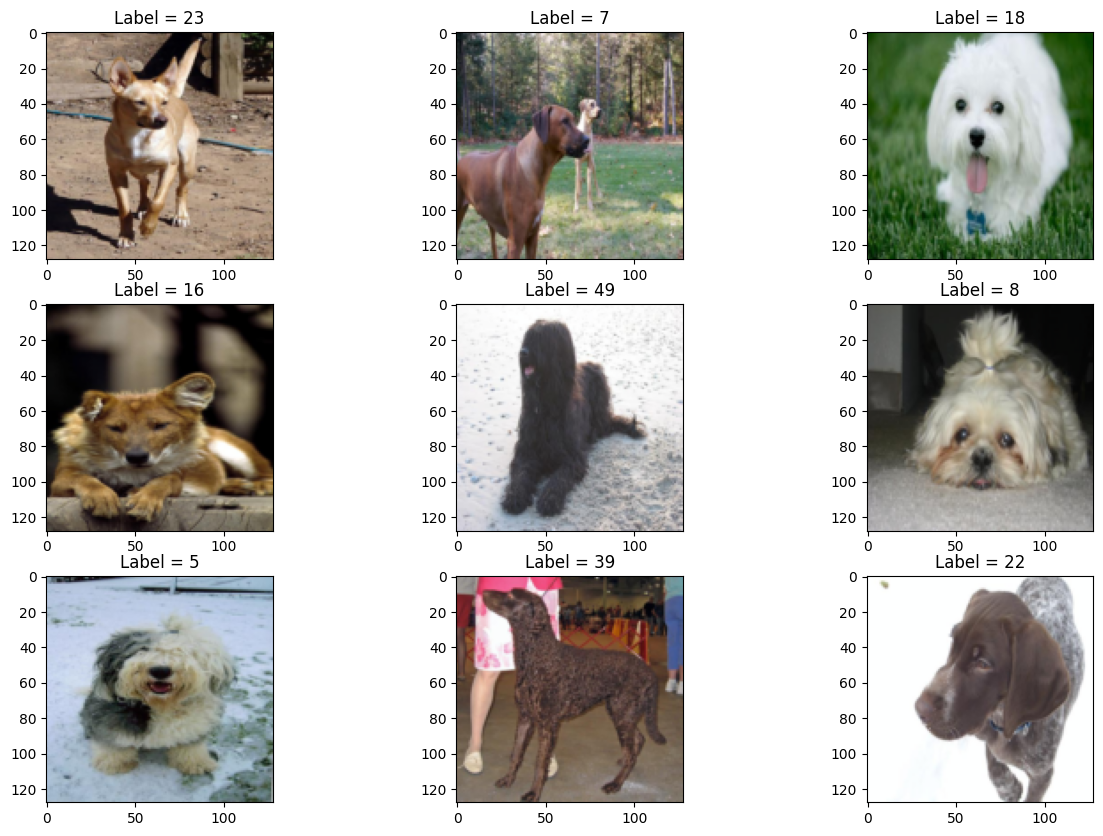

In [10]:
plot_from_batch_generator(train_loader)

In [11]:
from IPython.display import clear_output

class Runner():
    def __init__(self, model, opt, device, criterion, metric, checkpoint_path=None):
        self.model = model
        self.opt = opt
        self.device = device
        self.criterion = criterion
        self.metric = metric
        self.checkpoint_path = checkpoint_path
        self.epoch = 0
        self.train_phase = True
        self.logits = None
        self._top_val_score = -1
        self.log_dict = {
            "train_loss": [],
            "val_loss": [],
            "train_score": [],
            "val_score": []}

    def forward(self, X_batch):
        logits = self.model(X_batch)
        return logits

    def _run_batch(self, batch):
        X_batch, _ = batch
        X_batch = X_batch.to(self.device)
        self.logits = self.forward(X_batch)

    def _run_criterion(self, batch):
        _, y_batch = batch
        y_batch = y_batch.to(self.device)
        loss = self.criterion(self.logits, y_batch)
        y_pred = torch.max(F.softmax(self.logits, dim=1), dim=1)[1]
        score = self.metric(y_pred, y_batch)
        return loss, score

    def _run_epoch(self, loader, output_log=True):
        ep_loss = []
        ep_score = []
        _phase_description = 'Training' if self.train_phase else 'Evaluation'
        for batch in tqdm(loader, desc=_phase_description, leave=False):
            self._run_batch(batch)

            with torch.set_grad_enabled(self.train_phase):
                loss, score = self._run_criterion(batch)

            if self.train_phase:
                loss.backward()
                self.opt.step()
                self.opt.zero_grad()

            ep_loss.append(loss.item())
            ep_score.append(score.item())

        if self.train_phase:
            self.log_dict['train_loss'].append(np.mean(ep_loss))
            self.log_dict['train_score'].append(np.mean(ep_score))
        else:
            self.log_dict['val_loss'].append(np.mean(ep_loss))
            self.log_dict['val_score'].append(np.mean(ep_score))

        if output_log:
            self.output_log()

    def save_checkpoint(self):
        val_score = self.log_dict['val_score'][-1]
        if val_score > self._top_val_score and self.checkpoint_path is not None:
            self._top_val_score = val_score
            if val_score > 0.6:
                torch.save(self.model, open(self.checkpoint_path, 'wb'))

    def load_checkpoint(self):
        if self.checkpoint_path is not None:
            self.model = torch.load(self.checkpoint_path)

    def output_log(self):
        if self.visualize:
            clear_output()

        phase = 'Training' if self.train_phase else 'Evaluation'

        print(f'{phase}: ', end='')
        if self.train_phase:
            print(f'Train loss: {self.log_dict["train_loss"][-1]}; Train score: {self.log_dict["train_score"][-1]}')
        else:
            print(f'Val loss: {self.log_dict["val_loss"][-1]}; Val score: {self.log_dict["val_score"][-1]}')
            #self.save_checkpoint()

        if self.visualize:
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))

            axes[0].set_title('Loss')
            axes[0].plot(self.log_dict["train_loss"], label='train')
            axes[0].plot(self.log_dict["val_loss"], label='validate')
            axes[0].legend()

            axes[1].set_title('Accuracy')
            axes[1].plot(self.log_dict["train_score"], label='train')
            axes[1].plot(self.log_dict["val_score"], label='validate')
            axes[1].legend()

            plt.show()


    def train(self, train_loader, val_loader, n_epochs, visualize=True, model=None, opt=None, criterion=None, metric=None):
        self.visualize = visualize
        self.opt = (opt or self.opt)
        self.model = (model or self.model)
        self.criterion = (criterion or self.criterion)
        self.metric = (metric or self.metric)
        self.train_phase = True
        self.model.train(self.train_phase)

        for _epoch in range(n_epochs):
            self.train_phase = True
            start_time = time.time()
            self.epoch += 1
            print(f"epoch {self.epoch:3d}/{n_epochs:3d} started")

            self._run_epoch(train_loader)

            print(f"epoch {self.epoch:3d}/{n_epochs:3d} took {time.time() - start_time:.2f}s")

            self.train_phase = False
            self.validate(val_loader)
            self.save_checkpoint()

    @torch.no_grad()
    def validate(self, loader):
        self.train_phase = False
        self.model.train(self.train_phase)
        self._run_epoch(loader)

    @torch.no_grad()
    def predict(self, X=None, loader=None):
        self.load_checkpoint()
        self.train_phase = False
        self.model.train(self.train_phase)
        if loader:
            pred_label = []
            for X_batch in tqdm(loader, desc='Test', leave=False):
                X_batch = X_batch.to(self.device)
                self.logits = self.forward(X_batch)
                y_pred = torch.max(F.softmax(self.logits, dim=1), dim=1)[1]
                pred_label.append(y_pred.item())
        if X:
            self.logits = self.forward(X)
            pred_label = torch.max(F.softmax(self.logits, dim=1), dim=1)[1]

        return pred_label


In [ ]:
#Base line model

def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.3),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.5),
        nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2))

class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()

        self.model = nn.Sequential(
            conv_block_3x3(3, 128, 1),
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten())
        self.dropout0_5 = nn.Dropout(p=0.5)
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU())

        self.pred = nn.Sequential(
            nn.Linear(128, NUM_CLASSES, bias=False))

    def forward(self, x):
        x = self.model(x)
        x = self.dropout0_5(x)
        x = self.fc(x)
        x = self.dropout0_5(x)
        x = self.pred(x)
        return x


In [ ]:
base_line_cnn = SimpleCNN()
summary(base_line_cnn, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             896
       BatchNorm2d-2         [-1, 32, 126, 126]              64
              ReLU-3         [-1, 32, 126, 126]               0
         MaxPool2d-4           [-1, 32, 63, 63]               0
           Dropout-5           [-1, 32, 63, 63]               0
            Conv2d-6           [-1, 64, 61, 61]          18,496
       BatchNorm2d-7           [-1, 64, 61, 61]             128
              ReLU-8           [-1, 64, 61, 61]               0
         MaxPool2d-9           [-1, 64, 30, 30]               0
          Dropout-10           [-1, 64, 30, 30]               0
           Conv2d-11          [-1, 128, 28, 28]          73,856
      BatchNorm2d-12          [-1, 128, 28, 28]             256
             ReLU-13          [-1, 128, 28, 28]               0
        MaxPool2d-14          [-1, 128,

Evaluation: Val loss: 3.7092364600726535; Val score: 0.2049053997865745


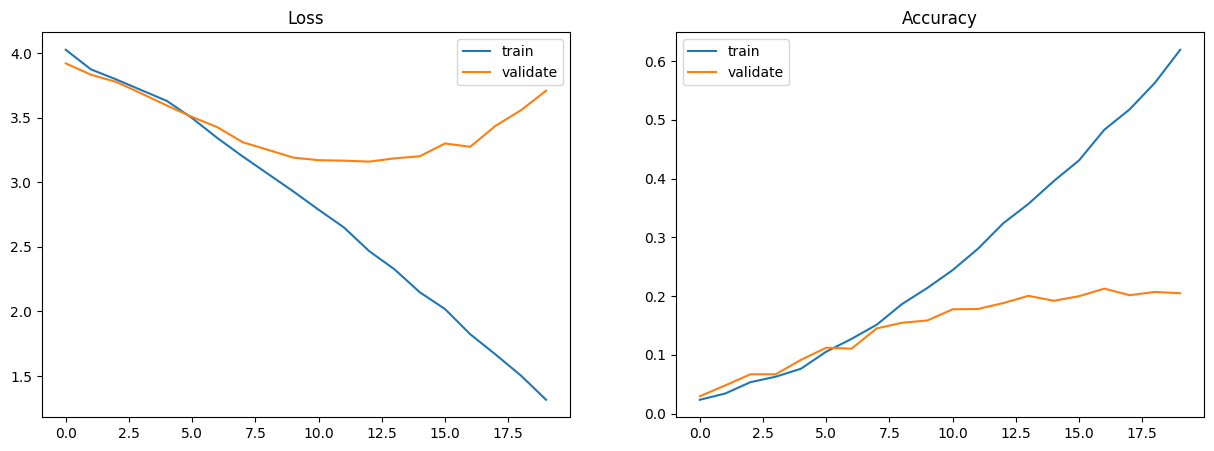

In [ ]:
base_line_cnn = base_line_cnn.to(device)
opt = torch.optim.Adam(base_line_cnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
checkpoint_path = r'base_line_cnn_model.ckpt'

runner_base_line = Runner(model=base_line_cnn, opt=opt, device=device,
                          criterion=criterion, metric=metric,
                          checkpoint_path=checkpoint_path)

runner_base_line.train(train_loader=train_loader,
                       val_loader=val_loader, n_epochs=20)


In [13]:
model_resnet50 = torchvision.models.resnet50(pretrained=True)

In [14]:
num_feat = model_resnet50.fc.in_features
num_feat

2048

In [ ]:
for name, p in model_resnet50.named_parameters():
    if not name.startswith('fc') or not name.startswith('layer4.2'):
        p.requires_grad_(False)

In [15]:
model_resnet50.fc = nn.Sequential(nn.Dropout(p=0.5),
                                  nn.Linear(num_feat, 512),
                                  nn.BatchNorm1d(512),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.3),
                                  nn.Linear(512, NUM_CLASSES))
model_resnet50 = model_resnet50.to(device)

In [16]:
summary(model_resnet50, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Evaluation: Val loss: 1.798244833946228; Val score: 0.6236422615391868


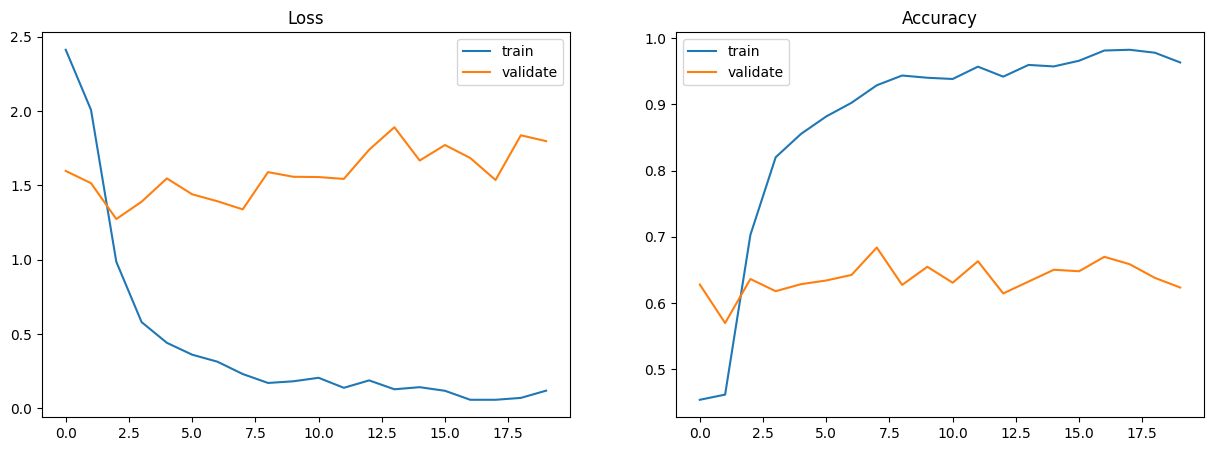

In [17]:
opt = torch.optim.Adam(model_resnet50.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
checkpoint_path = 'model_resnet_18_finetune.ckpt'

runner_base_line = Runner(model=model_resnet50, opt=opt, device=device,
                          criterion=criterion, metric=metric,
                          checkpoint_path=checkpoint_path)

runner_base_line.train(train_loader=train_loader,
                       val_loader=val_loader, n_epochs=20)